In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import random
import time
from monai.networks.nets import BasicUNet
from monai.losses.dice import GeneralizedDiceLoss

In [2]:
class CellDataset(Dataset):
    def __init__(self, well_folders, brightfield_dir, mask_dir, transform=None, augment=False):
        """
        Initialize the dataset with a list of well folders.
        """
        self.brightfield_dir = brightfield_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augment = augment

        # Store all images and their corresponding well folders
        self.image_paths = []
        self.masks_paths = []

        for well_folder in well_folders:
            well_path = os.path.join(brightfield_dir, well_folder)
    
            images = sorted([f for f in os.listdir(well_path) if f.endswith('z06c2_ORG.tif')])
            for img in images:
                image_path = os.path.join(well_path, img)

                # Extract sample prefix for mask lookup
                sample_prefix = image_path.split('_')[4].split('z')[0]  # Adjust based on your filename structure
                mask_filename = f"Alexa488_Fibroblasts_well1_50locations_{sample_prefix}z06c1_ORG_mask.tiff"
                mask_path_full = os.path.join(mask_dir, mask_filename)
                # Verify if the mask exists
                if not os.path.exists(mask_path_full):
                    mask_path_full = os.path.join(mask_dir, f"{mask_dir}/{well_folder}_{sample_prefix}z06c1_ORGmask.tiff")

                if os.path.exists(mask_path_full):
                    self.image_paths.append(image_path)
                    self.masks_paths.append(mask_path_full)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the single image
        image_path = self.image_paths[idx]
        image = np.array(Image.open(image_path).convert('L'))  # Load as grayscale
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # Shape: (1, H, W)

        # Load the corresponding mask
        mask_path_full = self.masks_paths[idx]
        mask = np.array(Image.open(mask_path_full).convert('L'))
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0  # Shape: (1, H, W)

        if self.augment:
            image, mask = self.apply_augmentations(image, mask)

        return image, mask

    def apply_augmentations(self, image, mask):
        # Apply the same random transformations to both image and mask
        if random.random() > 0.5:  # Horizontal flip
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random.random() > 0.5:  # Vertical flip
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        if random.random() > 0.5:  # Random rotation
            angle = random.uniform(-180, 180)  
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        return image, mask

print("..................this is unet with one image as input....................")   
batch_size = 2 #normally 16 
num_epochs = 10 #normally 30 
learning_rate = 0.001

# Define lists of folders for training, validation, and testing
train_folders = ['train', 'train','train','train','train','train','train']
val_folders = ['valandtest','valandtest']
test_folders = ['valandtest']

val_dataset = CellDataset(val_folders, "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data", "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data/valandtest", augment=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CellDataset(test_folders, "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data", "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data/valandtest", augment=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# For training set, enable augmentation
train_dataset = CellDataset(train_folders, "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data", "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data/train", augment=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Testing samples: {len(test_loader.dataset)}")


..................this is unet with one image as input....................
Training samples: 7
Validation samples: 2
Testing samples: 1


In [3]:
class EnhancedCNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(1024, 1024)):
        super(EnhancedCNN, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # First Block: 64 filters
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Downsample by 2x

            # Second Block: 128 filters
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # Third Block: 256 filters
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Binary segmentation output
        )
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = self.dropout(x)  # Apply dropout to encoder output
        
        # Decoder
        segmentation_output = self.decoder(x)
        
        return segmentation_output

In [4]:
num_gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

# Initialize model, loss function, and optimizer
model = BasicUNet(
    spatial_dims=2,  
    in_channels=1,
    out_channels=2,
    features = (32, 64, 128, 256, 512, 32),
    dropout=0.2
)
"""Change the model to CNN here"""
#model = EnhancedCNN(input_channels=11)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adjust the learning rate as needed
GDL = GeneralizedDiceLoss(include_background=False,to_onehot_y=True,softmax=False)
#criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for segmentation (only for cnn)

avg_train_losses = []
avg_val_losses = [] 
train_losses = []
val_losses = []
epoch_losses =[]
val_epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    batch_count = 0

    for inputs, masks in train_loader:
        # Move data to device (e.g., GPU if available)
        inputs = inputs.to(device)

        masks = masks.to(device)
        
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.softmax(dim=1)

        # Calculate loss (using continuous output from sigmoid)
        loss = GDL(outputs, masks)
        train_losses.append(loss.item())
        epoch_loss += loss.item()
        batch_count += 1

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for each epoch
    epoch_loss = epoch_loss / batch_count
    epoch_losses.append(epoch_loss)
    print("Epoch: {}, Train Loss: {}".format(epoch, epoch_loss))

    # Evaluation/Validation step (optional)
    model.eval()
    with torch.no_grad():
        val_epoch_loss = 0.0
        val_batch_count = 0
        for val_inputs, val_masks in val_loader:  # Or use a separate validation loader
            val_inputs = val_inputs.to(device)
            val_masks = val_masks.to(device)


            prediction = model(val_inputs)
            prediction = prediction.softmax(dim=1)
            
            loss = GDL(prediction, val_masks)
            val_losses.append(loss.item())
            val_epoch_loss += loss.item()
            val_batch_count += 1

    val_epoch_loss = val_epoch_loss / val_batch_count
    val_epoch_losses.append(val_epoch_loss)
    print("Epoch: {},  Val Loss: {}".format(epoch, val_epoch_loss))

BasicUNet features: (32, 64, 128, 256, 512, 32).
Epoch: 0, Train Loss: 0.6495616137981415
Epoch: 0,  Val Loss: 0.5001349449157715
Epoch: 1, Train Loss: 0.5978938490152359
Epoch: 1,  Val Loss: 0.45357102155685425
Epoch: 2, Train Loss: 0.5491197407245636
Epoch: 2,  Val Loss: 0.46347883343696594
Epoch: 3, Train Loss: 0.5266933292150497
Epoch: 3,  Val Loss: 0.4352824091911316
Epoch: 4, Train Loss: 0.5289171934127808
Epoch: 4,  Val Loss: 0.372970849275589
Epoch: 5, Train Loss: 0.47545647621154785
Epoch: 5,  Val Loss: 0.3580135107040405
Epoch: 6, Train Loss: 0.48263583332300186
Epoch: 6,  Val Loss: 0.337396502494812
Epoch: 7, Train Loss: 0.47241730242967606
Epoch: 7,  Val Loss: 0.3863174021244049
Epoch: 8, Train Loss: 0.43740636110305786
Epoch: 8,  Val Loss: 0.35334521532058716
Epoch: 9, Train Loss: 0.4230574443936348
Epoch: 9,  Val Loss: 0.29933542013168335


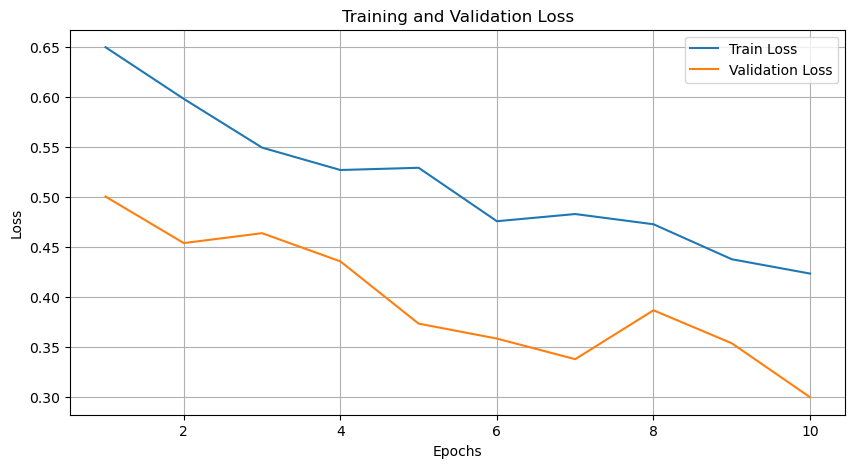

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

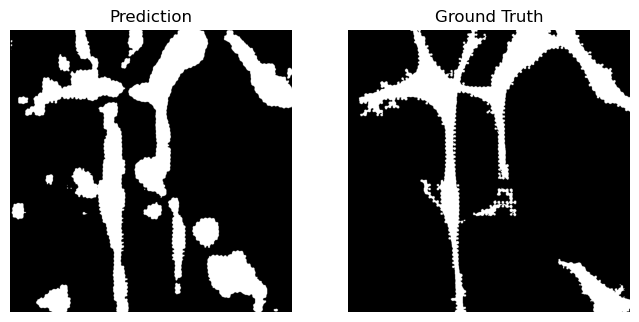

In [6]:
def compute_iou(preds, targets):
    """
    Compute the Intersection over Union (IoU) score.

    Args:
        preds (torch.Tensor): Predicted masks (logits or probabilities).
        targets (torch.Tensor): Ground truth masks.

    Returns:
        float: IoU score.
    """
    # Binarize predictions based on the threshold
    # Ensure inputs are binary (optional, for safety)
    preds = preds.float()
    targets = targets.float()

    # Compute intersection and union
    intersection = torch.sum(preds * targets)
    union = torch.sum(preds + targets) - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0  # Perfect score if both are empty

    return intersection / union

test_loss = 0.0
iou_test = 0.0
total_samples = len(test_loader.dataset)

with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass through the model
        segmentation_output = model(images)
        segmentation_output = segmentation_output.softmax(dim=1)
        
        # Calculate the loss
        loss = GDL(segmentation_output, masks)
        test_loss += loss.item()
        
        preds = torch.argmax(segmentation_output, dim=1)

        # Compute IoU for the batch
        batch_iou = compute_iou(preds, masks)
        iou_test += batch_iou.item() * images.size(0)  # Scale by batch size
        for i in range(preds.shape[0]):
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            # Move prediction to CPU before converting to NumPy
            axes[0].imshow(preds[i].cpu().numpy(), cmap='gray')
            axes[0].set_title('Prediction')
            axes[0].axis('off')
            # Show original mask
            axes[1].imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
            plt.show()


In [7]:
# Compute average test loss and IoU
test_loss /= len(test_loader)
average_iou = iou_test / total_samples
print(f"Test Loss: {test_loss:.4f}")
print(f"IoU: {average_iou:.4f}")

Test Loss: 0.3011
IoU: 0.5085
